<a href="https://colab.research.google.com/github/Nacho2904/orga_de_datos/blob/main/tp4_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Yu-Gi-Oh Style Transfer

En este notebook implementaremos un algoritmo de **Neural Style Transfer** (NST) basado en [Gatys et al.](https://arxiv.org/pdf/1508.06576.pdf). Para más información acerca de las diferentes formas de NSS, también tenemos [este otro paper](https://arxiv.org/abs/1705.04058).

## Overview del problema y el método

"In fine art, especially painting, humans have mastered the skill to create unique
visual experiences through composing a complex interplay between the content and style of an image. Thus far the algorithmic basis of this process is
unknown and there exists no artificial system with similar capabilities. However, in other key areas of visual perception such as object and face recognition
near-human performance was recently demonstrated by a class of biologically
inspired vision models called Deep Neural Networks. Here we introduce an
artificial system based on a Deep Neural Network that creates artistic images
of high perceptual quality. The system uses neural representations to separate and recombine content and style of arbitrary images, providing a neural
algorithm for the creation of artistic images. Moreover, in light of the striking similarities between performance-optimised artificial neural networks and
biological vision, our work offers a path forward to an algorithmic under-
standing of how humans create and perceive artistic imagery."

En problemas de **Style Transfer**, buscamos utilizar el **contenido** de una imagen $x_c$ y el **estilo** de una imagen $x_s$ para sintetizar una imagen que muestra los objetos de $x_c$ con el estilo de $x_s$.

 ![Ejemplo de Style Transfer](https://github.com/Nacho2904/orga_de_datos/raw/main/screen.jpg)

Por lo tanto, el problema se reduce a encontrar una manera de poder obtener tanto el **estilo** de una imagen $x_s$ (muy relacionado con su **textura**, por lo que ambos términos serán usados de forma intercambiable) y el **contenido** de una imagen $x_c$, y luego encontrar la mejor imagen posible que se ajuste a ambos.

Más generalmente, podemos relacionar la extracción de contenido de una imagen con problemas de **síntesis de información o reducción de dimensionalidad**. Lo que estamos buscando es un **feature map** que nos resuma las partes relevantes de la imagen y que nos permita reconstruir su contenido en base a ello.

Por otro lado, el problema de **modelado de texturas visuales** es un problema considerablemente más complejo que no es tan fácil de encasillar. Resumidamente, hay dos formas de atacarlo: el **modelado paramétrico de texturas** utiliza métodos estadísticos para describir la imagen, por ejemplo usando correlaciones entre diferentes lugares de la imagen, mientras que el **modelado no paramétrico mediante campos aleatorios de Markov** utiliza técnicas probabilísticas para modelar pixeles y sus vecindarios.

Finalmente, también necesitamos recontruir la imagen a partir de un resumen del contenido y del estilo. Para ello también hay varios métodos posibles dependiendo de qué utilizamos para extraer el contenido y el estilo.

Un ejemplo muy simple posible de Style Transfer sería reducir la dimensionalidad de la imagen de contenido mediante una técnica de dimensionality reduction como PCA que extraería el contenido de la imagen (antes habría que preprocesar la imagen para que tenga las dimensiones adecuadas, además de que habría que aplicarle filtros). Con el PCA entrenado en un conjunto de imágenes con el estilo deseado, podríamos aplicar un algoritmo de clustering sobre el espacio de dimensionalidad baja como $KMeans$.

Con ello, podríamos reducir $x_c$ al espacio latente para resumir su contenido, y buscar el centroide más cercano $\mu_s$ y utilizarlo como media para una distribución normal, cuya covarianza sería la matriz de covarianza de los factores latentes del PCA. De esta forma, el centroide nos daría el contenido y la matriz de covarianza, el estilo. 

### Neural Style Transfer

Cuando utilizamos una red neuronal convolucional (CNN) sobre imágenes generalmente lo que buscamos es modelar una distribución $p(y|x)$, donde $y \in \mathcal{Y}$, $\mathcal{Y}$ siendo el conjunto de clases, y $x \in \mathbb{R}^{C \times H \times W}$ es la imagen que queremos clasificar, con $C$ la cantidad de **canales**, $H$ y $W$ la altura y ancho. 

Dentro de la red neuronal, esencialmente el modelo va reduciendo progresivamente la dimensionalidad de la imagen mediante una combinación de layers de filtro (layers de $convolución$) y layers de $pooling$. 

El paper del que extraemos el método explora la posibilidad de utilizar los outputs de los layers de convolución (que efectivamente es una reducción de dimensiones de la imagen original) como **feature maps** que extraen el contenido de la imagen, y utilizar estadísticas de dichos feature maps como representaciones del estilo de la imagen, pudiendo simultáneamente obtener una forma de extraer el estilo y el contenido mediante el entrenamiento de una CNN en una tarea de clasificación.

<div>
<img src="https://github.com/Nacho2904/orga_de_datos/raw/main/screen01.jpg" width="700"/>
</div>


En la imagen de arriba vemos la doble funcionalidad de la CNN para extraer contenido y estilo. Vemos que a medida que el downsampling realizado por los pooling layers va reduciendo la dimensionalidad de la imagen, la reconstrucción se vuelve menos certera (pues perdemos información). En cambio, dicha condensación de información hace que cuando queremos extraer el estilo de la imagen, podamos reconstruir más fielmente dicho estilo con las layers más altas.

## Implementación

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import PIL
import pathlib
from google.colab import drive
from zipfile import ZipFile
drive.mount('/content/gdrive')

### Importando las imágenes

In [ ]:
!cp '/content/drive/MyDrive/cards.zip' cards.zip

In [ ]:
with ZipFile("cards.zip", 'r') as zObject:

	# Extracting all the members of the zip
	# into a specific location.
	zObject.extractall(
		path="cards_folder")


In [ ]:
data_dir = pathlib.Path("cards_folder/cards")
[x for x in data_dir.iterdir()][:5]

[PosixPath('cards_folder/cards/04611269.jpg'),
 PosixPath('cards_folder/cards/22386234.jpg'),
 PosixPath('cards_folder/cards/36304921.jpg'),
 PosixPath('cards_folder/cards/98898173.jpg'),
 PosixPath('cards_folder/cards/27062594.jpg')]

In [ ]:
image_count = len(list(data_dir.glob('**/*.jpg')))
print(image_count)

11426


Vemos que tenemos 11426 imágenes. Mostramos algunas de ellas

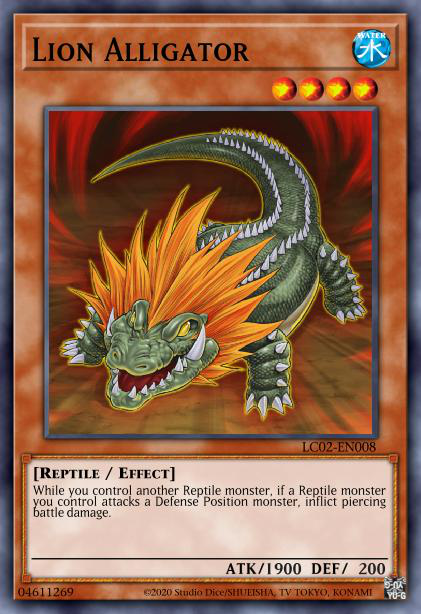

In [ ]:
images = list(data_dir.glob('**/*.jpg'))
PIL.Image.open(str(images[0]))

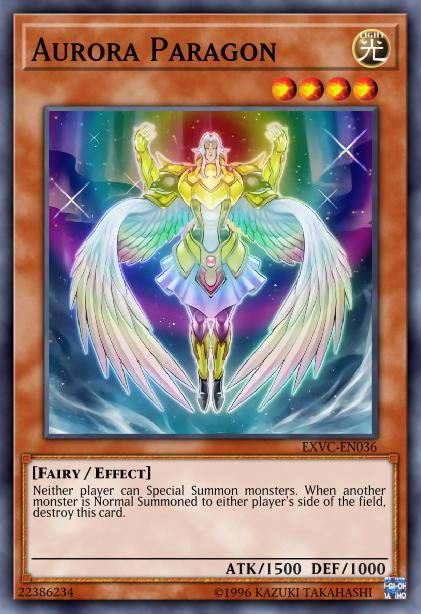

In [ ]:
PIL.Image.open(str(images[1]))

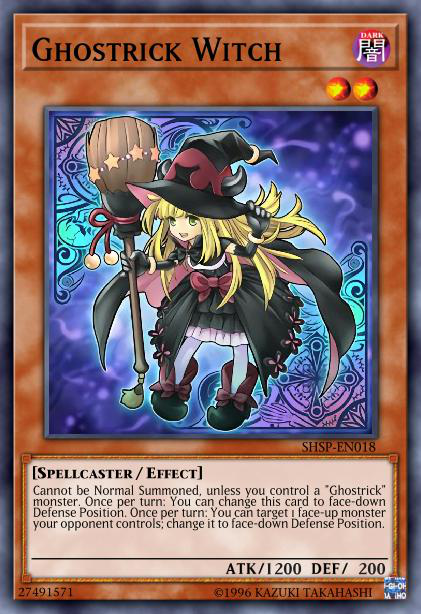

In [ ]:
PIL.Image.open(str(images[700]))

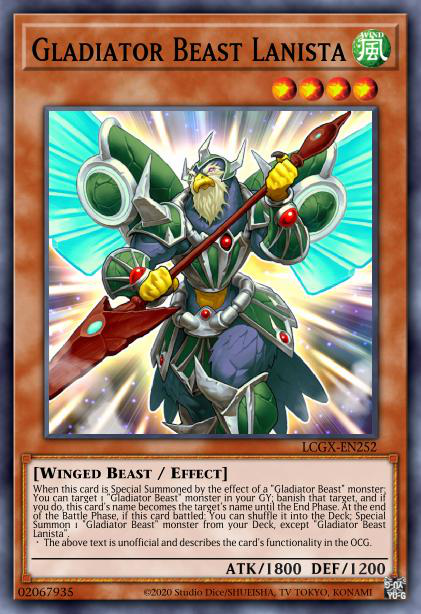

In [ ]:
PIL.Image.open(str(images[-1]))